<a href="https://colab.research.google.com/github/guiraposo/PINNs_for_Gravity/blob/main/Simple_Examples/Waves_on_Strings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Oscillations and Waves.

<br>

<a href="https://colab.research.google.com/github/raimonluna/MachineLearningForStrongGravity/blob/main/Lecture1_Physics_Informed_Neural_Networks.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

### In this notebook we will see:
1. How to use PINNs to solve differential equations, including ODEs, PDEs and eigenvalue problems.<br>Original paper:<br>

 - Maziar Raissi, Paris Perdikaris, George Em Karniadakis, <i>Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations</i>, Journal of Computational Physics, 378, 686-707, 2019. https://arxiv.org/abs/1711.10561

We will apply it to the study os waves and oscillations of a string. Notebook based on the strong gravity lectures of Raimon Luna.
<br>

In [2]:
import numpy as np
import sympy as sp



import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
from IPython import display
import matplotlib.gridspec as gridspec

from matplotlib import animation
from IPython.display import HTML

In [3]:
def gradients(outputs, inputs, order = 1):
    if order == 1:
        return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]
    elif order > 1:
        return gradients(gradients(outputs, inputs, 1), inputs, order - 1)
    else:
        return outputs

def generate_2Dgrid(range1, range2, Ns, requires_grad = True):
    grid1 = np.linspace(range1[0], range1[1], Ns[0], dtype = np.float32)
    grid2 = np.linspace(range2[0], range2[1], Ns[1], dtype = np.float32)
    x0, y0 = np.meshgrid(grid1, grid2)
    x = torch.tensor(x0.reshape(Ns[0]*Ns[1], 1), requires_grad = requires_grad)
    y = torch.tensor(y0.reshape(Ns[0]*Ns[1], 1), requires_grad = requires_grad)
    return x, y

def plot_form(x, y, z):
    Nx  = x.unique().shape[0]
    Ny = y.unique().shape[0]
    return map(lambda t: t.reshape(Ny, Nx).cpu().detach().numpy(), (x, y, z))

# 1. Solving a system of ODEs: Sine and Cosine
## Here we follow the example given in the [MachineLearningForStrongGravity](https://github.com/raimonluna/)
Here we solve the system of ODEs for the sine and cosine functions.

$$s'(x) = c(x),$$
$$c'(x) = -s(x),$$

In [73]:
c = sp.Function('c')
s = sp.Function('s')
x = sp.symbols('x')

In [74]:
diff_eq1 = sp.Eq(c(x).diff(x), -s(x))
diff_eq2 = sp.Eq(s(x).diff(x), c(x))

solution = sp.dsolve([diff_eq1,diff_eq2], [s(x),c(x)])
print(solution)



[Eq(s(x), C1*sin(x) + C2*cos(x)), Eq(c(x), C1*cos(x) - C2*sin(x))]


As expected the solutions are of the form $c(x)=A\cos(x + \psi)$ and $s(x)=A\sin(x + \psi)$.

Let us set the initial conditions as in order to fix the phase and amplitude.

$$s(0) = 0, \;c(0) = 1.$$
<br>

In [78]:
solution = sp.dsolve([diff_eq1,diff_eq2], [c(x),s(x)], ics={s(0): 0, c(0): 1})

In [79]:
solution_exprs = [sol.rhs for sol in solution] #get the expressions for the functions.
numerical_sols = [sp.lambdify(x, expr, 'numpy') for expr in solution_exprs] #convert from simpy to numpy


In [80]:
solution[1]

Eq(s(x), sin(x))

Let us know use a Neural Network to solve the same equation, with the same boundary conditions. We will start by setting the boundary conditions by weak enforcement.

In [26]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 2),
        ) # 1 hidden layer should be enough

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.1)
                nn.init.constant_(m.bias, val = 0.0) # standard initialization

    def forward(self, x):
        return self.net(x)

class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x):

        funcs  = self.ode(x)

        c, s = map(lambda i:  funcs[:,[i]], range(2))
        dc = gradients(c, x)
        ds = gradients(s, x)

        zero_vals = self.ode(torch.zeros(1,1))

        eq_loss = torch.mean((dc + s)**2 + (ds - c)**2) # loss of differential equation. Should be zero if the equations are satisfied.
        ic_loss = (zero_vals[0,0] - 1)**2 + zero_vals[0,1]**2 # Loss for the boundary conditions. Should be zero if the boundary conditions are satisfied.

        return eq_loss, ic_loss


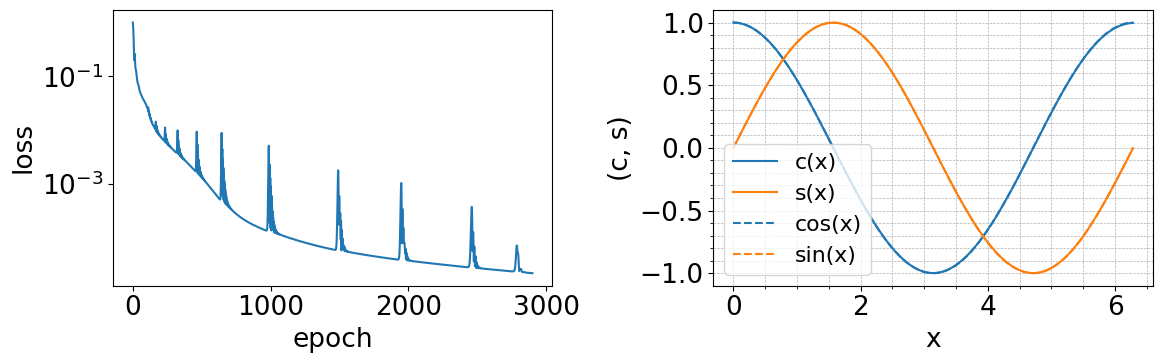

In [84]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []

optimizer = optim.Adam(ode.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.1)**(1/5000))

x = torch.tensor(np.linspace(0, 2 * np.pi, 100, dtype = np.float32)).reshape(100, 1)
x.requires_grad = True

x_vals = np.linspace(0, 2*np.pi, 100)
c_vals = numerical_sols[0](x_vals)
s_vals = numerical_sols[1](x_vals)


################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(3000):
    try:
        optimizer.zero_grad()

        eq_loss, ic_loss = odeloss(x)
        loss = eq_loss + ic_loss
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())

        if epoch % 100 == 0:

            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)

            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('(c, s)')
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 0].cpu().detach().numpy())
            ax2.plot(x.cpu().detach().numpy(), ode(x)[:, 1].cpu().detach().numpy())
            ax2.plot(x_vals, c_vals, color='#1f77b4', linestyle = '--') #Plot for the exact solution of cosine
            ax2.plot(x_vals, s_vals, color = '#ff7f0e', linestyle = '--') #Plot for the exact solution of sine

            ax2.legend(["c(x)","s(x)", "cos(x)", "sin(x)"], fontsize='small')
            plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

            plt.minorticks_on()


            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()

    except KeyboardInterrupt:
        break


As expected the $c(x)$ function represents the cosine and the $s(x)$ represents the sine. The loss function decreases and is low, validating also the method. Just by looking at the plot youy can see that the solutions of the PINN approximate very well the exact solutions.


# Simple Eigenvalue Problem: Vibrating String

Let us consider the case of a oscillating string. The equation that governs waves on strings is given by (we set $c=1$ for simplicity):

$$-\frac{\partial^2 \Psi(t,x)}{\partial t^2} +\frac{\partial^2 \Psi(t,x)}{\partial x^2}=0 $$.

Instead of solving the full partial differential equation (PDE), it is often useful to look at the frequency-domain by taking the fourier decomposition of the function.

$$ $$

By doing this transformation our single PDE reduces to a system of infinite (but separable) ordinary differential equations (ODEs).

$$\psi''(x) + \lambda^2 \psi(x) = 0$$

One option is to provide a value of $\lambda$ and solve the equation. Another option is to impose boundary conditions and reduce this equation to an eigenvalue problem.


Here we want to apply NNs to solve the eigenvalue problem


$$\psi''(x) + \lambda^2 \psi(x) = 0, \quad {\rm with} \quad \psi(0) = \psi(1) = 0.$$

Let us start by checking what we expect the solution to be:
<br>

In [4]:
psi = sp.Function('psi')
x = sp.symbols('x')
lam = sp.symbols('lam')

In [5]:
diff_eq1 = sp.Eq(psi(x).diff(x).diff(x) , - lam ** 2 * psi(x))

solution = sp.dsolve(diff_eq1, psi(x))
print(solution)



Eq(psi(x), C1*exp(-I*lam*x) + C2*exp(I*lam*x))


In [6]:
C1, C2 = sp.symbols('C1 C2')
general_solution = solution.rhs  # Get the right-hand side of the solution


In [7]:
# Apply the first boundary condition f(0) = 0
bc1 = general_solution.subs(x, 0).subs(psi(0), 0)
solutions = sp.solve((bc1), (C2), dict=True)
print(solutions)
replaced_solution = general_solution.subs(C2,-C1) #This is the solution with the boundary condition at x=0 satisfied
print(replaced_solution)


[{C2: -C1}]
-C1*exp(I*lam*x) + C1*exp(-I*lam*x)


We can easily see the expression at x=1:

In [111]:
replaced_solution.subs(x,1)

-C1*exp(I*lam) + C1*exp(-I*lam)

It is easy to see that this boundary condition is only satisfied when

$$\lambda = n \times \pi, $$
and $n$ is an integer number.

Our neural network should find sinusoidal solutions with this eigenvalue.

In [8]:
class ODE(nn.Module):
    def __init__(self):
        super(ODE, self).__init__()

        self.lam = nn.Parameter(torch.tensor(5., requires_grad=True))  # Adjusted for the first overtone

        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.GELU(),
            nn.Linear(40, 40),
            nn.GELU(),
            nn.Linear(40, 1),
        ) # 1 hidden layer is enough

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean = 0, std = 0.3)
                nn.init.constant_(m.bias, val = 0)

    def forward(self, x):
        return self.net(x) * x * (1 - x) #This is another way to force the boundary conditions
def node_penalty(f, expected_sign_changes=1):
    """
    Calculate a penalty based on the absence of expected sign changes (nodes) in the solution.

    Parameters:
    - f: Tensor containing the neural network outputs for the discretized domain x.
    - expected_sign_changes: The expected number of sign changes in the solution for the first overtone.

    Returns:
    - A penalty term that can be added to the loss function.
    """
    # Calculate the sign of f at each point
    sign_f = torch.sign(f)

    # Calculate the difference in sign between consecutive elements
    # A non-zero difference indicates a sign change
    product_consecutive = f[1:] * f[:-1] #If the product of two consecutive numbers is negative, it means that the sign changed. (if the function is oscillating around 0)

    sign_changes =  (product_consecutive < 0).float()



    # Count the number of sign changes (non-zero entries imply a sign change)
    num_sign_changes = torch.sum(sign_changes).float()

    # Calculate the penalty as the squared difference between the observed and expected sign changes
    penalty = (((num_sign_changes - expected_sign_changes) ** 2))/(expected_sign_changes + num_sign_changes+0.001) ** 2

    return penalty, num_sign_changes

class ODELoss(nn.Module):
    def __init__(self, ode):
        super(ODELoss, self).__init__()
        self.ode = ode

    def forward(self, x):
        f  = self.ode(x)
        d2f = gradients(f, x, 2)
        base_loss = torch.mean((d2f + f*self.ode.lam**2)**2)
        regularization = torch.mean(torch.abs(torch.abs(f) - 0.5))
        #regularization = 0
        # Node penalty encouraging the presence of a node (zero crossing)
        node_penalty_term , num_sign_changes_term = node_penalty(f)
        loss = base_loss + 0.1*regularization  +  node_penalty_term
      #  loss = torch.mean((d2f + f*self.ode.lam**2)**2+ (torch.mean(f) )**2)

        return loss, node_penalty_term, num_sign_changes_term, regularization

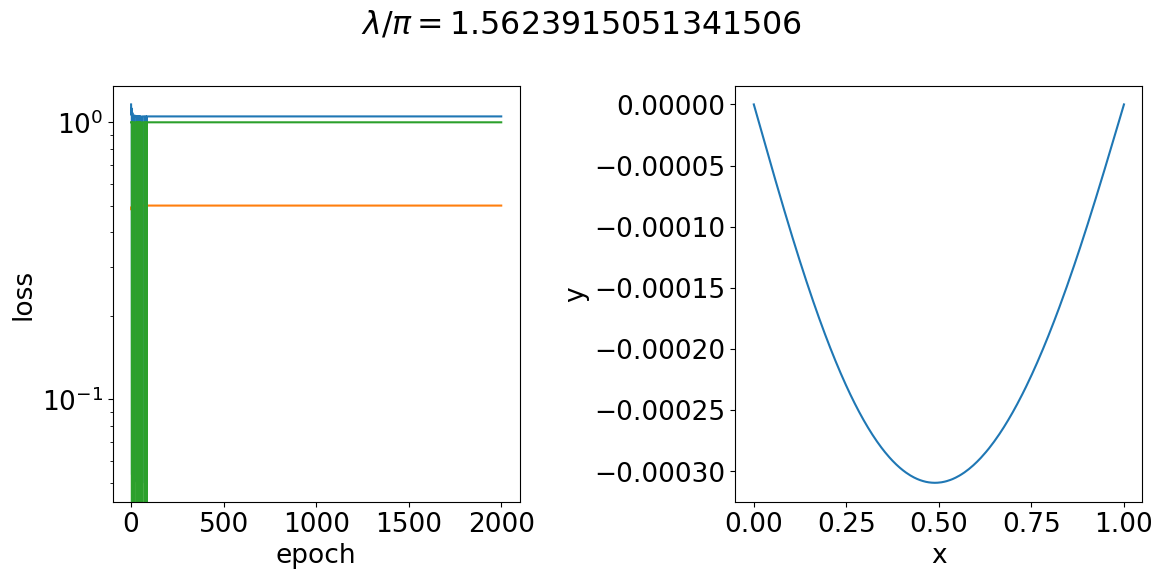

In [9]:
ode = ODE()
odeloss = ODELoss(ode)
loss_hist = []
regularization_loss_hist = [] #For checking the contribution of the regularization loss.
node_loss_hist = [] # For checking the contribution of the node loss.

optimizer = optim.Adam(ode.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=(0.01)**(1/2000))
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

x = torch.tensor(np.linspace(0, 1, 500, dtype = np.float32)).reshape(500, 1)
x.requires_grad = True

################## Training and Plotting ##################

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 6));
font = {'size'   : 19}
plt.rc('font', **font)

for epoch in range(2001):
    try:
        optimizer.zero_grad()

        loss, node_penalty_term, num_sign_changes_term, regularization_term = odeloss(x)
        loss.backward()
        optimizer.step()

        scheduler.step()
        loss_hist.append(loss.item())
        regularization_loss_hist.append(regularization_term.item())
        node_loss_hist.append(node_penalty_term.item())

        if epoch % 100 == 0:
            #print(f"Epoch {epoch}, Node Penalty Term: {node_penalty_term.item()}, Sign changes: {num_sign_changes_term.item()}")
            plt.suptitle(f'$\lambda/\pi = {ode.lam.item() / np.pi}$')

            ax1.cla()
            ax1.set_xlabel('epoch')
            ax1.set_ylabel('loss')
            ax1.set_yscale('log')
            ax1.plot(loss_hist)
            ax1.plot(regularization_loss_hist)
            ax1.plot(node_loss_hist)

            ax2.cla()
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            ax2.plot(x.cpu().detach().numpy(), ode(x).cpu().detach().numpy())

            display.display(plt.gcf())
            display.clear_output(wait=True)
            plt.tight_layout()

    except KeyboardInterrupt:
        break


Finding the fundamental mode is easy.
However the network is having trouble finding higher overtones.